In [1]:
%config InlineBackend.figure_format = 'retina'


In [2]:
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from time import time, ctime
import warnings
from astropy.table import Table
from astropy.modeling.fitting import LevMarLSQFitter, LMLSQFitter
from astropy.stats import sigma_clipped_stats, gaussian_fwhm_to_sigma
from astropy.table import Table, vstack, hstack
from astropy.nddata import NDData, CCDData, Cutout2D
from astropy.utils.exceptions import AstropyWarning
from astropy.visualization import simple_norm, ZScaleInterval
from photutils.aperture import CircularAperture, ApertureStats
from photutils.detection import DAOStarFinder, find_peaks
from photutils.psf import extract_stars, EPSFBuilder
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.psf import DAOPhotPSFPhotometry, BasicPSFPhotometry
from photutils.detection import IRAFStarFinder
from photutils.psf import DAOGroup, DBSCANGroup, IntegratedGaussianPRF
from photutils.background import MMMBackground, MADStdBackgroundRMS
from photutils.segmentation import make_source_mask
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
import sep

plt.rcParams["font.family"] = 'Times New Roman'
plt.rcParams["font.size"] = 15
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = 'cm'

warnings.simplefilter('ignore', category=AstropyWarning)

HOME = Path.home()
DATADIR = HOME/'class'/'tao23'/'TAO23'/'tutorials'/'data'/'proj2'

In [3]:
def zscale_imshow(ax, img, vmin=None, vmax=None, **kwargs):
    if vmin==None or vmax==None:
        interval = ZScaleInterval()
        _vmin, _vmax = interval.get_limits(img)
        if vmin==None:
            vmin = _vmin
        if vmax==None:
            vmax = _vmax
    im = ax.imshow(img, vmin=vmin, vmax=vmax, origin='lower', **kwargs)
    
    return im

def read_sci_data(fpath, show=True, newbyteorder=False, bkgsubtract=False):
    ccd_raw = CCDData.read(fpath, unit='nmgy') # be careful about the unit!
    ccd = CCDData.read(fpath, unit='nmgy')
    
    data = ccd.data
    
    data_mean, data_med, data_std = sigma_clipped_stats(data, sigma=2.)
    ccd.mask = data < data_mean - 3*data_std 
    ccd.data[ccd.mask] = data_med
    ccd.data -= data_med
    ccd.mask = (ccd.mask) & (data > 10.)
    if newbyteorder:
        ccd.data = ccd.data.byteswap().newbyteorder()
        
    n = len(ccd.data)
    if bkgsubtract:
        bkgsubs = []
        for i in range(n):
            bkgsub = background_substraction(ccd.data[i])
            bkgsubs.append(bkgsub)
        ccd.data = np.array(bkgsubs)
    
    if show:
        fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
        for i in range(n):
            im = zscale_imshow(axes[i], ccd.data[i], cmap='gray')
            divider = make_axes_locatable(axes[i])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')
            
            band = ccd.header[f'BAND{i}']
            
            axes[i].text(0.98, 0.02, f'${band}$-band',
                         transform=axes[i].transAxes,
                         va='bottom', ha='right', c='k',
                         bbox=dict(boxstyle='round', facecolor='w', alpha=0.9))
            
        plt.tight_layout()
        
    return ccd, ccd_raw

def background_substraction(img, box=100, filt=3, show=True):
    mask = make_source_mask(img, nsigma=2, npixels=1, dilate_size=3)
    bkg_sep = sep.Background(img.byteswap().newbyteorder(), 
                             mask=mask, bw=box, bh=box, fw=filt, fh=filt)
    bkgsub_sep = img - bkg_sep.back()
    
    if show:
        fig, axs = plt.subplots(2, 3, figsize=(10, 8))
        axs[1, 1].axis("off")
        
        data2plot = [
            dict(ax=axs[0, 0], arr=img,              title="Original data"),
            dict(ax=axs[0, 1], arr=bkg_sep.back(),   title=f"bkg (filt={filt:d}, box={box:d})"),
            dict(ax=axs[0, 2], arr=bkgsub_sep,       title="bkg subtracted"),
            dict(ax=axs[1, 0], arr=mask,             title="Mask"),
            # dict(ax=axs[1, 1], arr=bkg_sep.background_mesh,   title="bkg mesh"),
            dict(ax=axs[1, 2], arr=10*bkg_sep.rms(), title="10 * bkg RMS")
        ]
        
        for dd in data2plot:
            im = zscale_imshow(dd['ax'], dd['arr'])
            cb = fig.colorbar(im, ax=dd['ax'], orientation='horizontal')
            cb.ax.set_xticklabels([f'{x:.3f}' for x in cb.get_ticks()])#, rotation=45)
            dd['ax'].set_title(dd['title'])
        
        plt.tight_layout()
    
    return bkgsub_sep

/var/folders/c3/0f663kw90xldstvklyr5nq9c0000gn/T/ipykernel_49009/4146682716.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_xticklabels([f'{x:.3f}' for x in cb.get_ticks()])#, rotation=45)
/var/folders/c3/0f663kw90xldstvklyr5nq9c0000gn/T/ipykernel_49009/4146682716.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_xticklabels([f'{x:.3f}' for x in cb.get_ticks()])#, rotation=45)
/var/folders/c3/0f663kw90xldstvklyr5nq9c0000gn/T/ipykernel_49009/4146682716.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_xticklabels([f'{x:.3f}' for x in cb.get_ticks()])#, rotation=45)


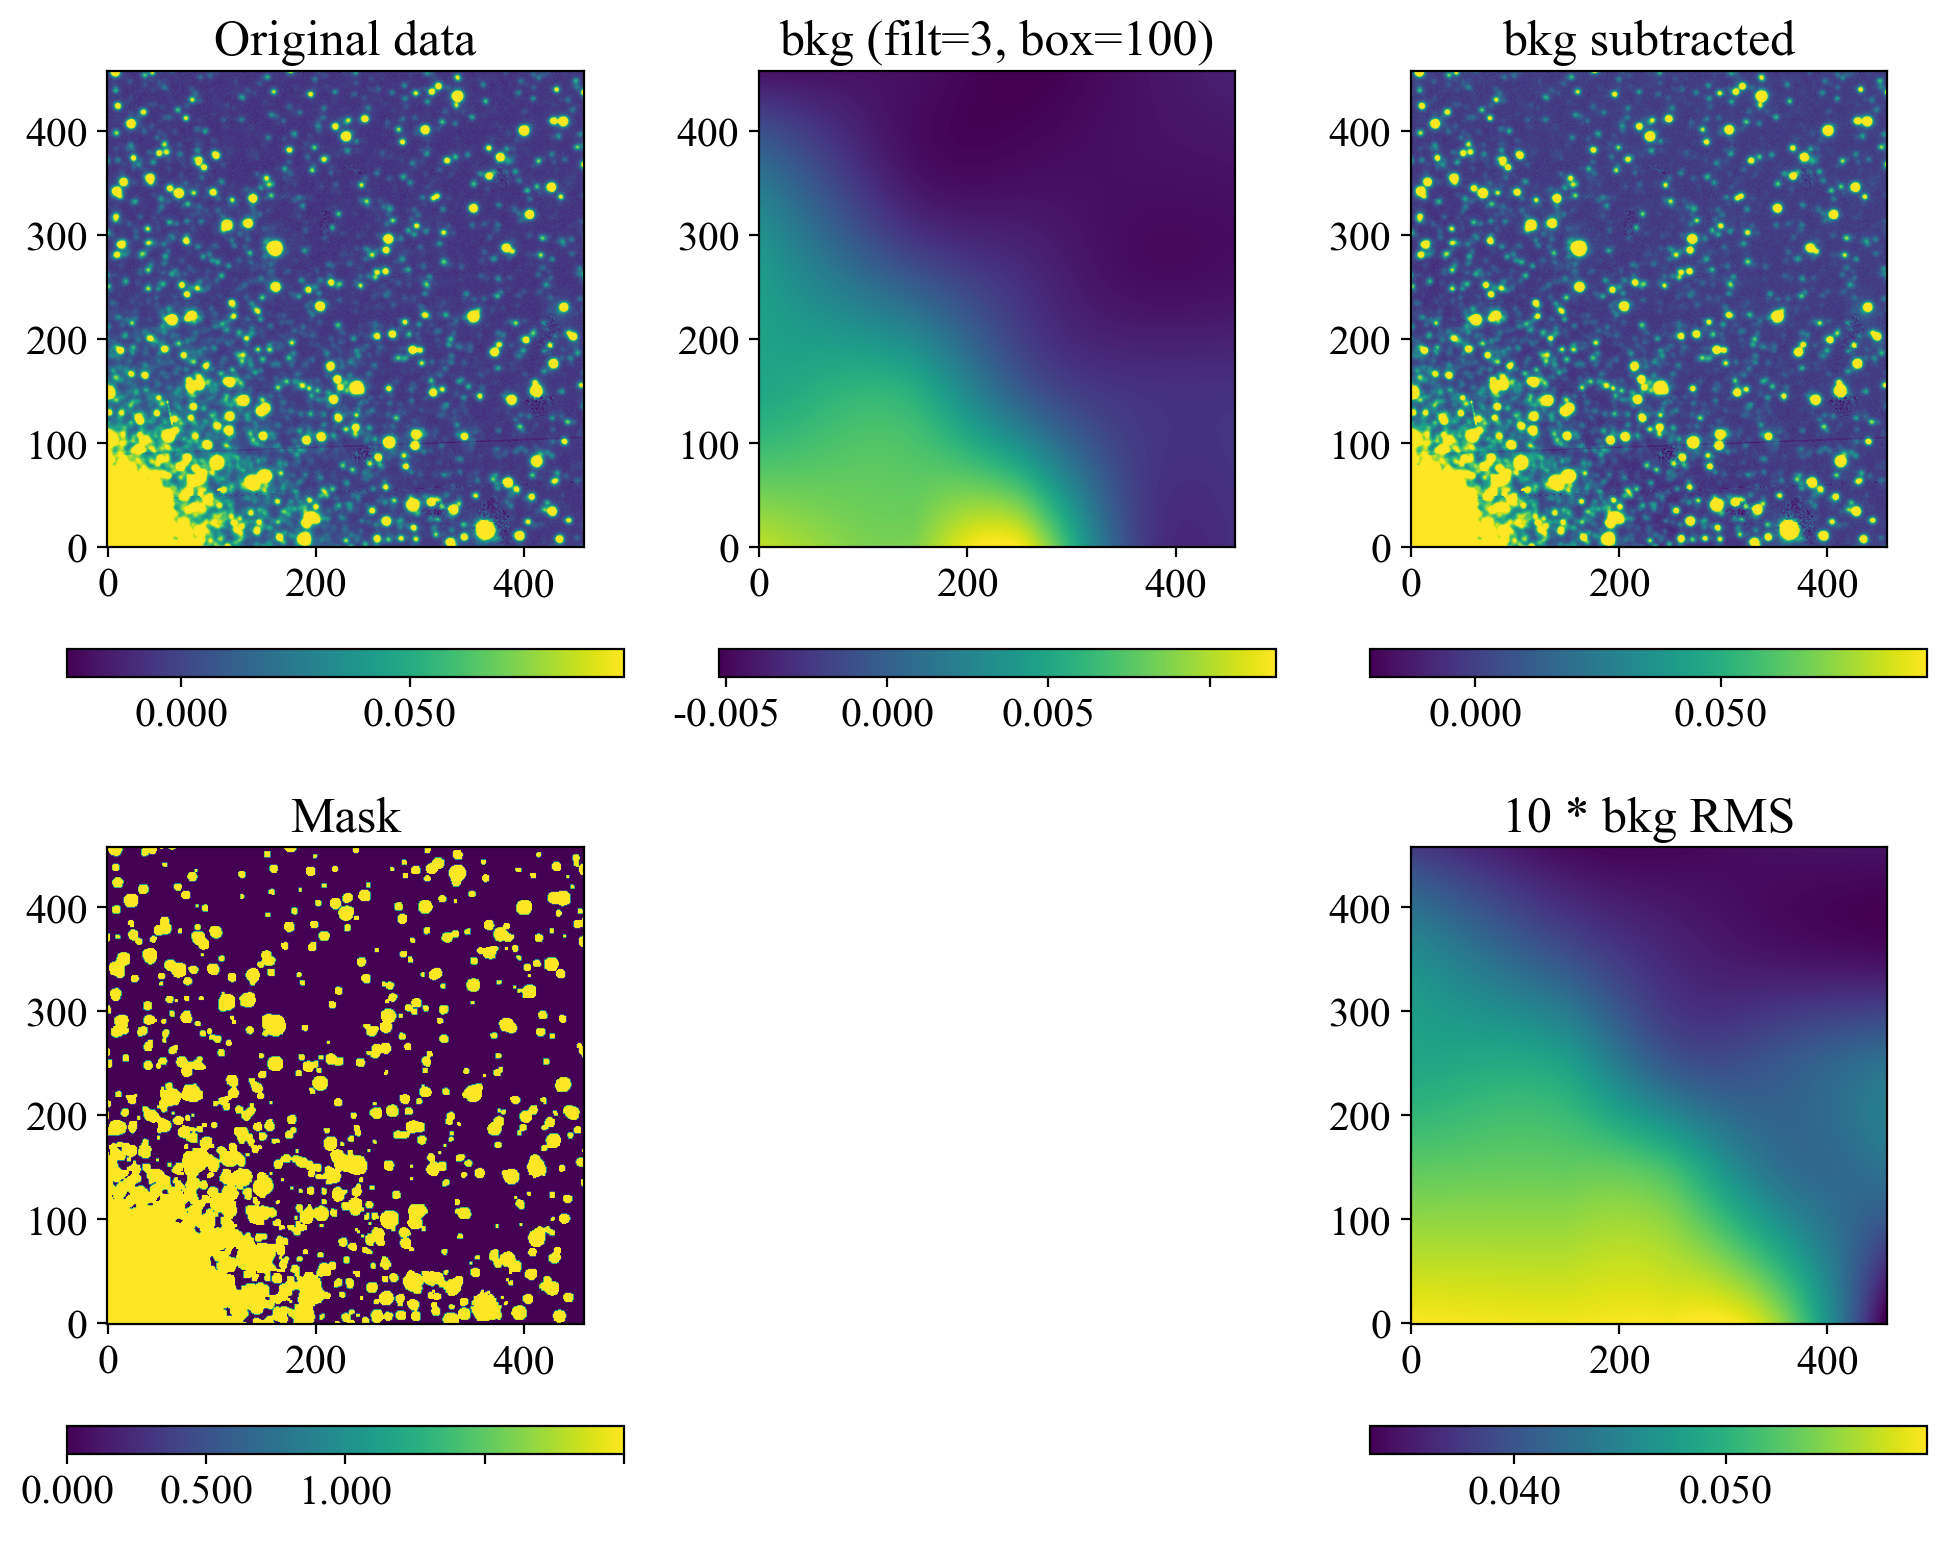

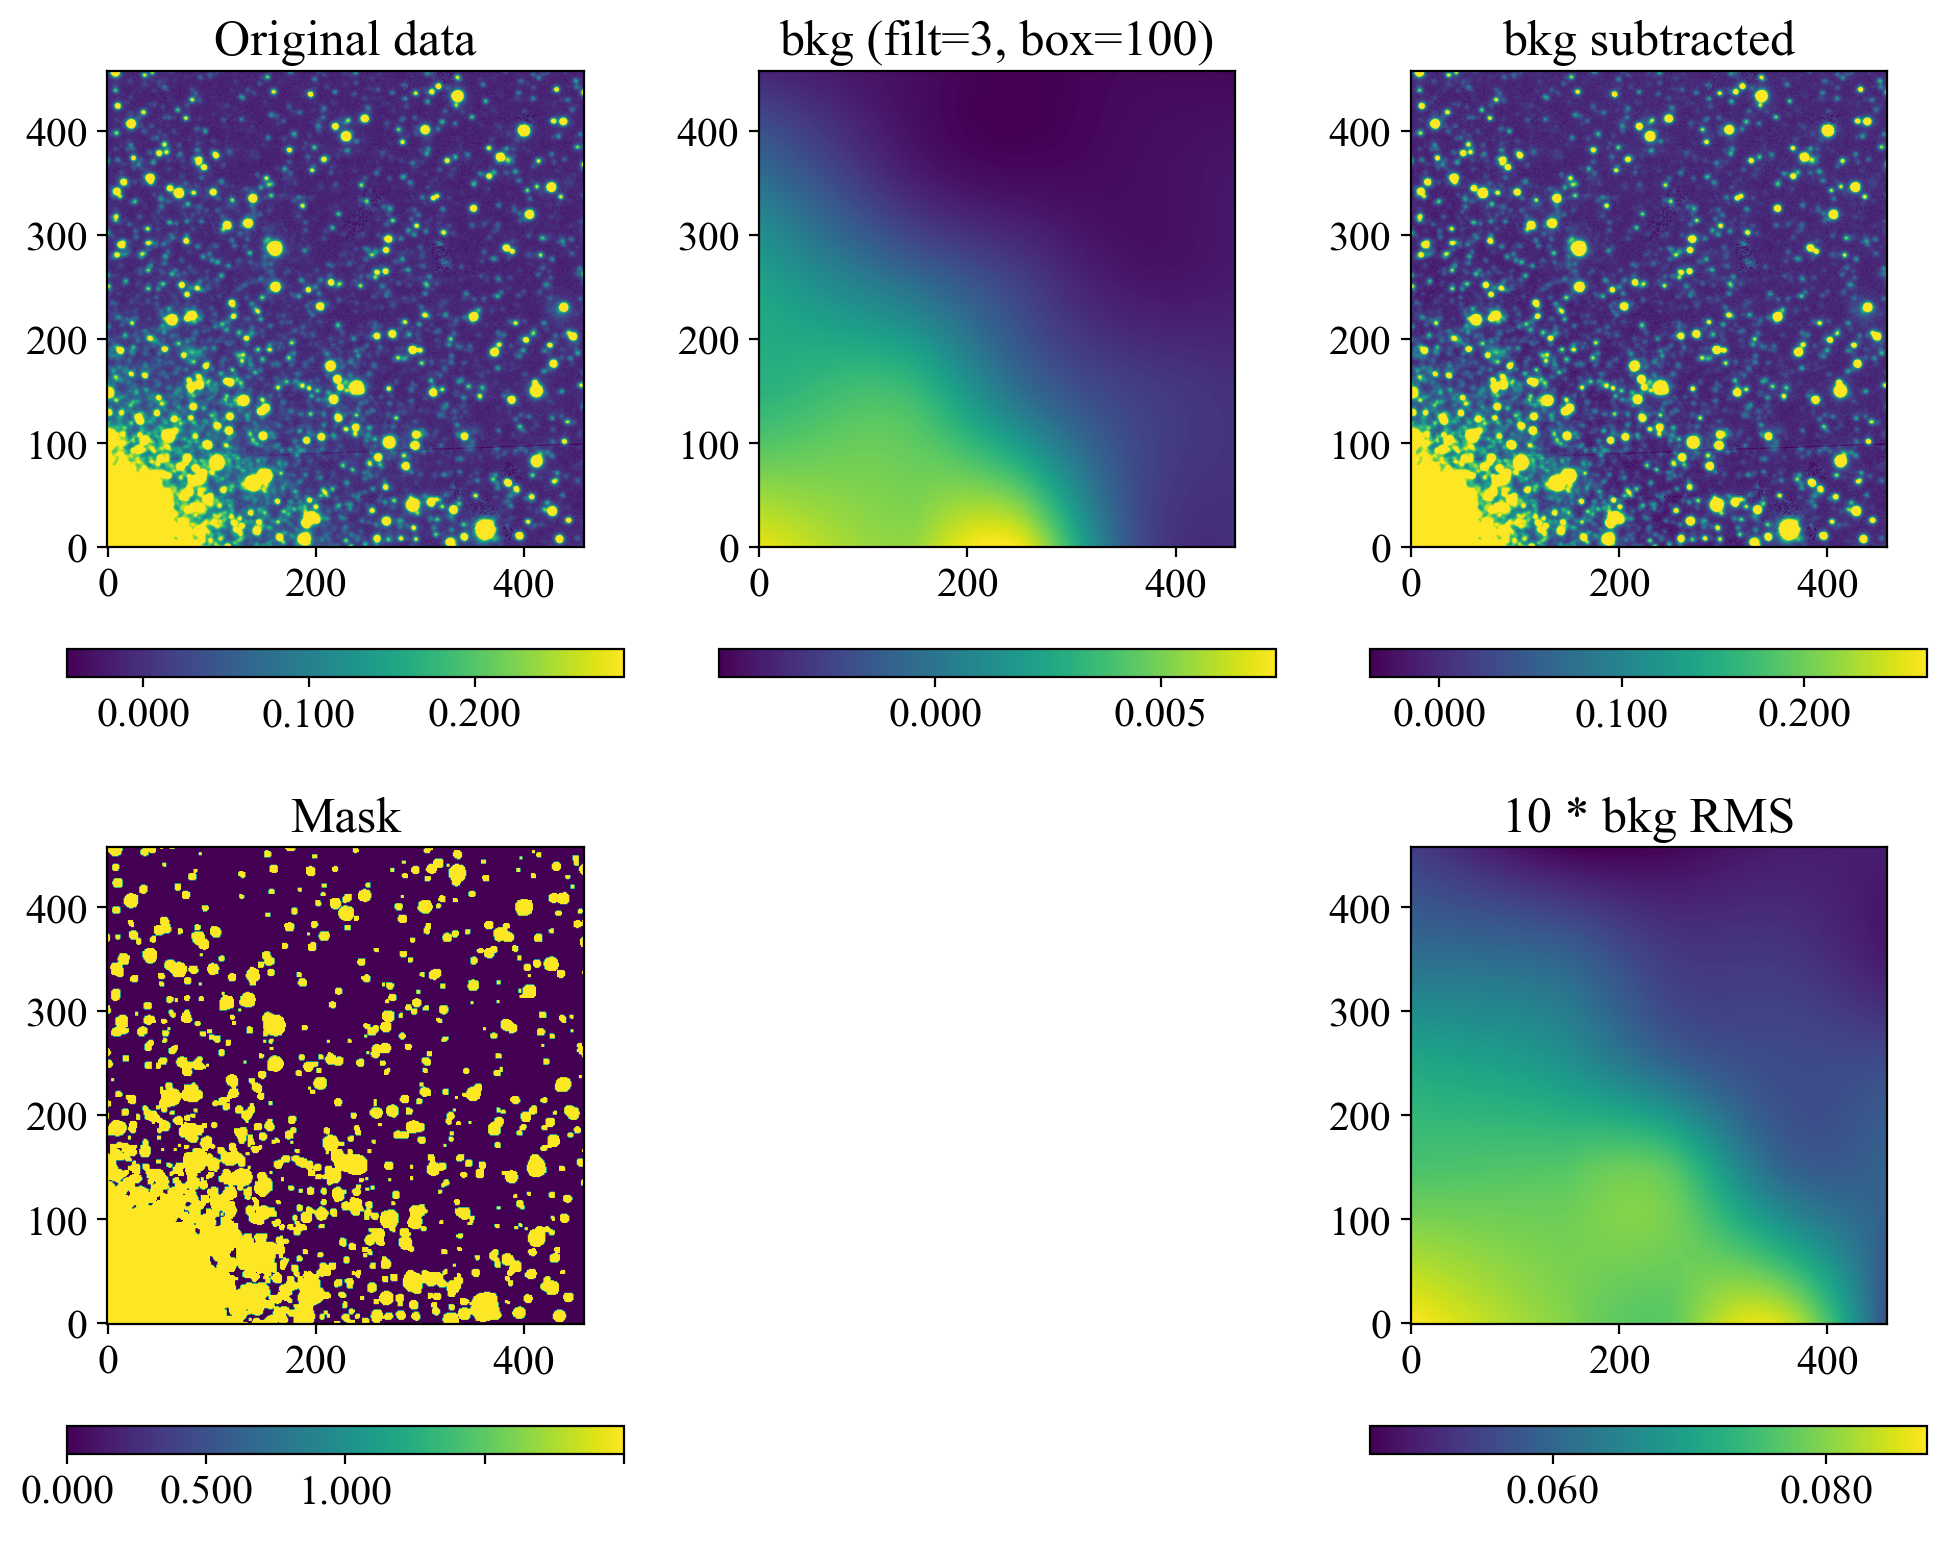

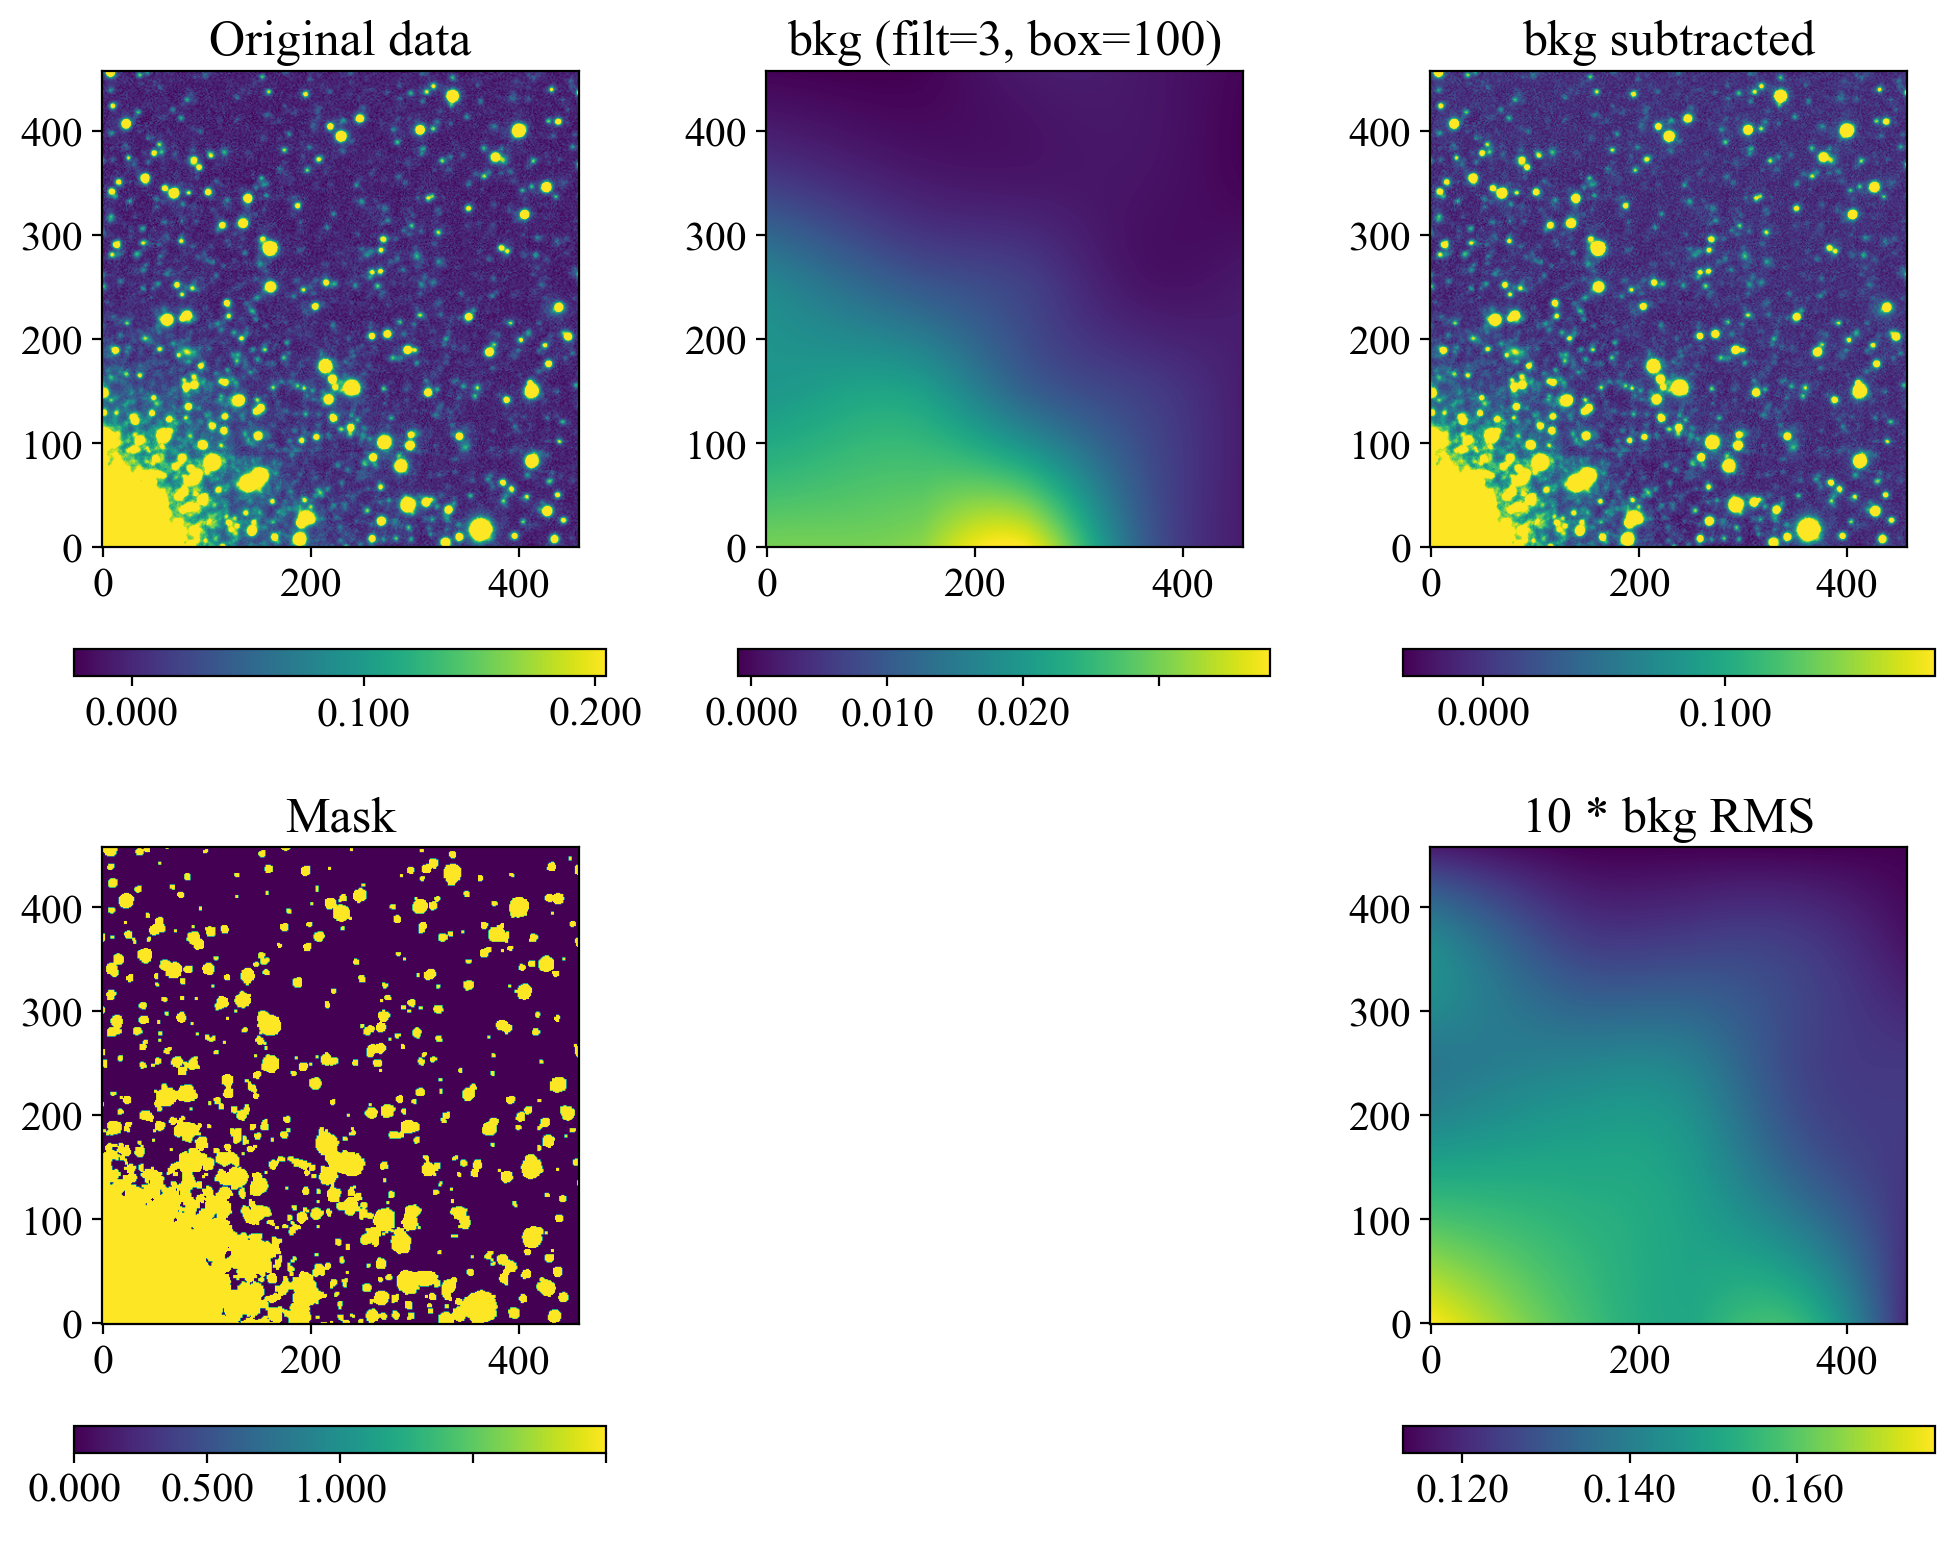

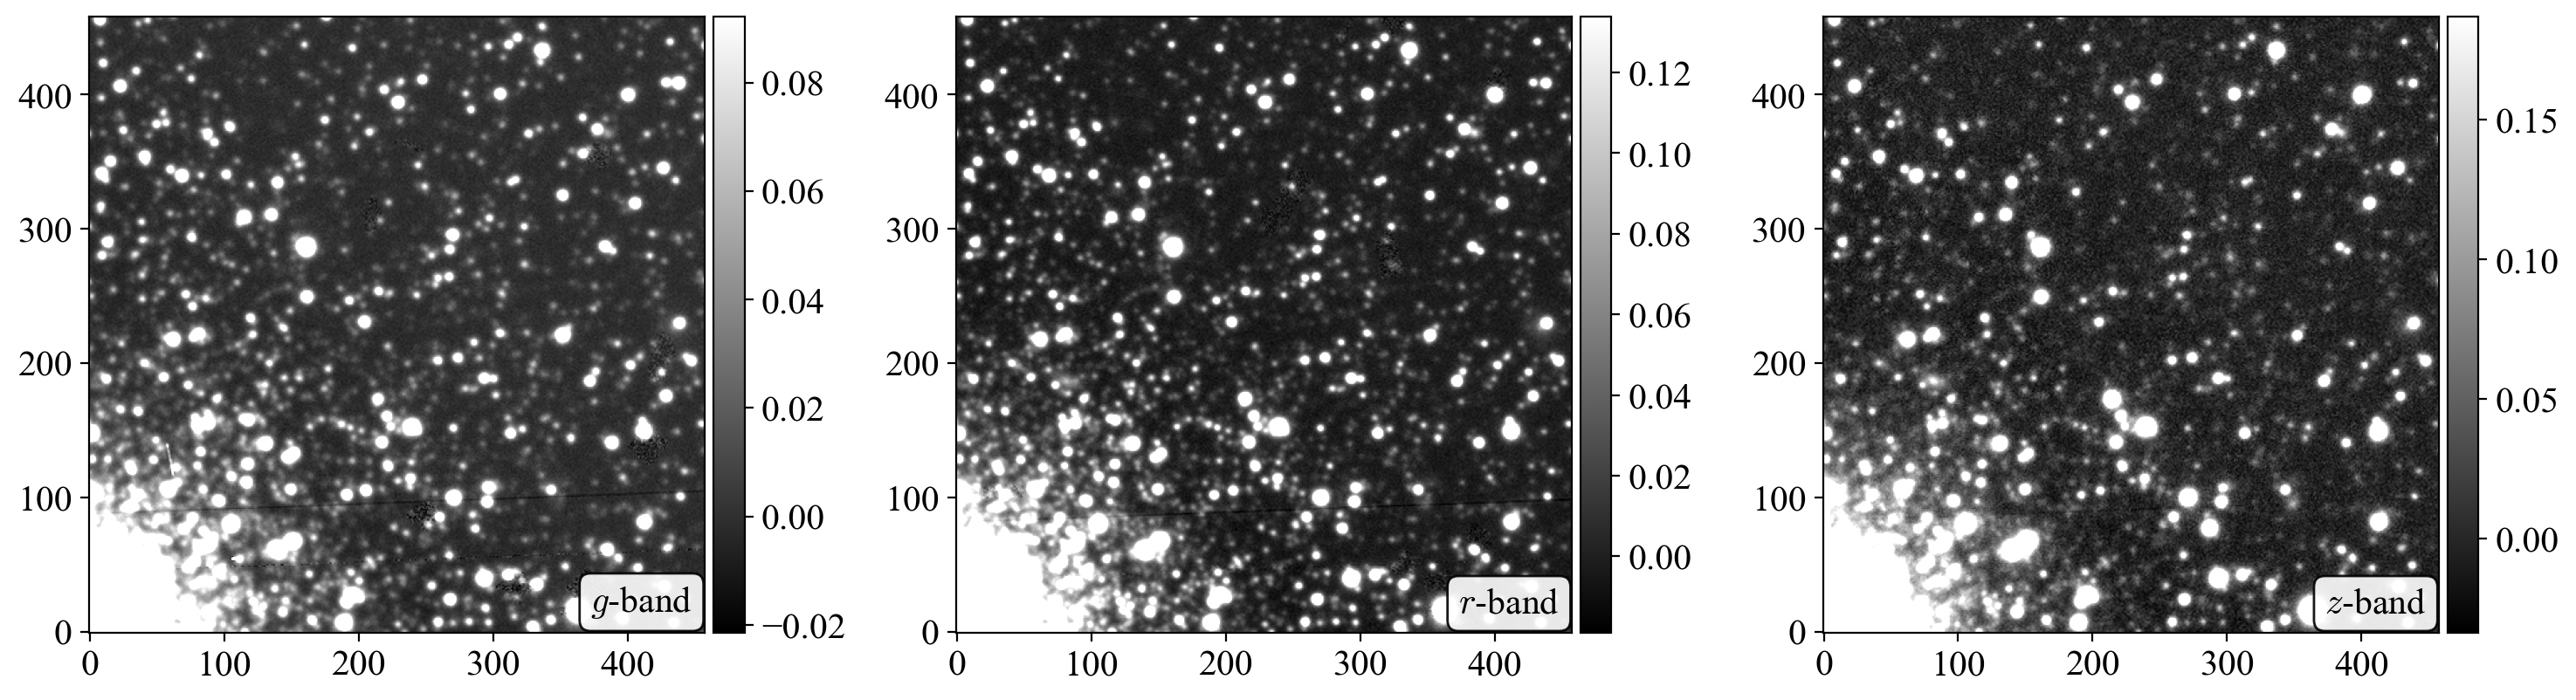

In [4]:
ccd, ccd_raw = read_sci_data(DATADIR/'NGC2210.grz.fits',bkgsubtract=True)

x_peak y_peak  peak_value
------ ------ -----------
   211      0 0.017702816
   221      0  0.02585933
   234      0 0.066292875
   397      0 0.015439065
   426      0  0.01929489
   456      0 0.025402183
   214      1 0.014840436
   248      2 0.057442136
   375      2 0.016039621
   203      3 0.015766898
   ...    ...         ...
   418    453 0.018741718
   307    454 0.047421437
     8    455  0.61997694
    43    455  0.10767186
   238    455 0.055923179
   202    456 0.019755991
   312    456 0.022179311
    52    457  0.02953851
    62    457 0.046513576
   176    457  0.36708906
   382    457 0.021643179
Length = 918 rows
 x   y 
--- ---
268  24
427  34
332  35
293  40
311  42
385  61
412  82
295  97
271 100
205 105
... ...
140 334
 69 339
426 345
 41 354
377 374
229 394
400 399
305 400
 23 406
438 408
336 432
Length = 42 rows


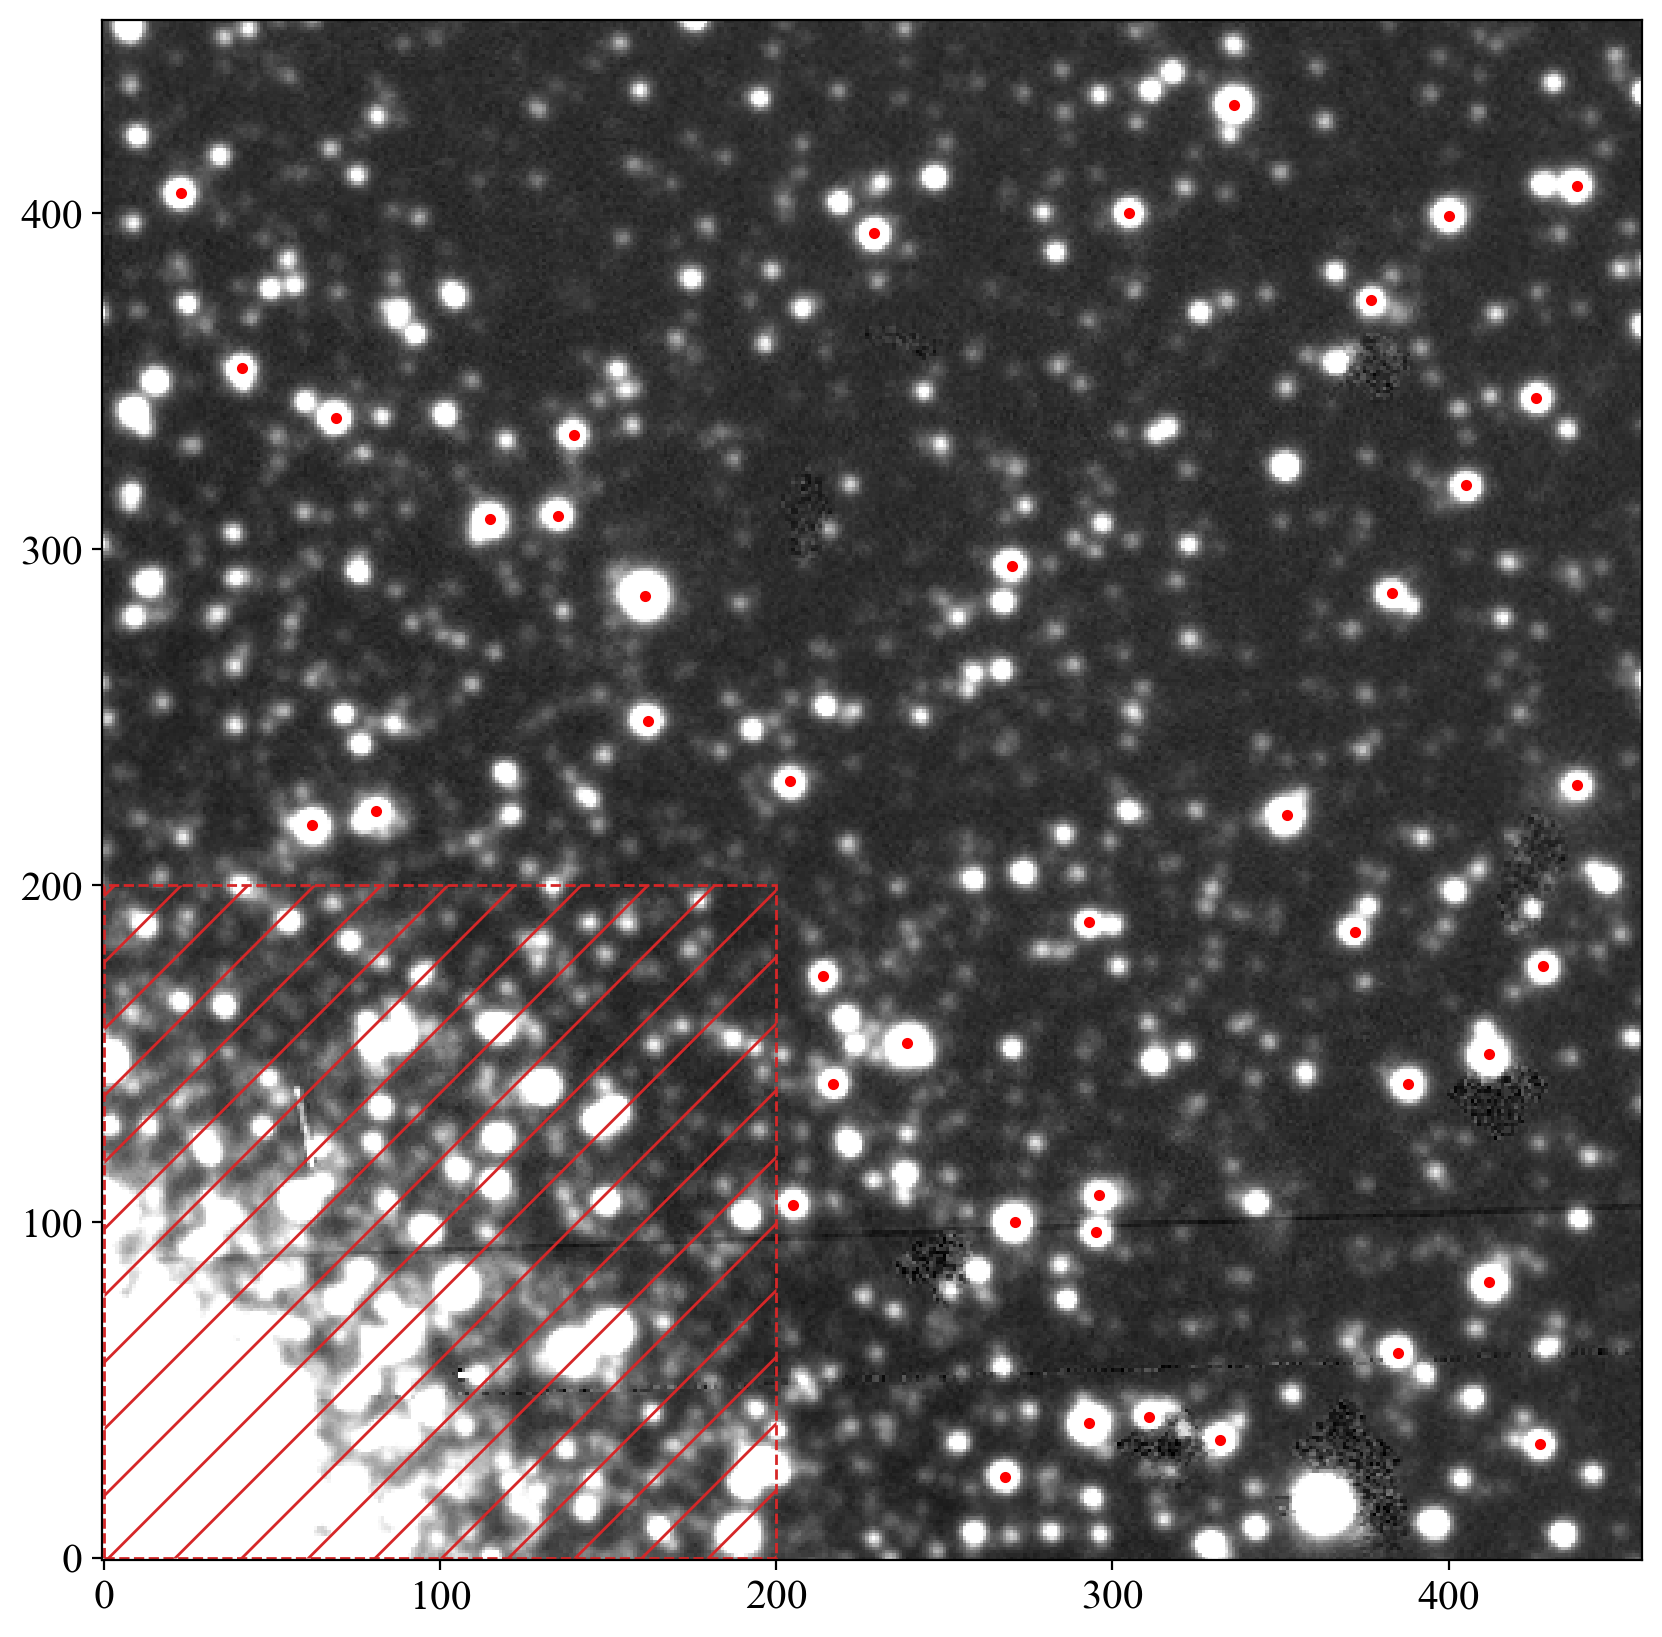

In [5]:
bands = ['g', 'r', 'z']
i = 0
band = bands[i]
data = ccd.data[i]
mask = ccd.mask[i]

bkgrms = MADStdBackgroundRMS()
std = bkgrms(data)
thres = 3*std

find_mask = np.zeros_like(data, dtype=bool)
# find_mask[250:650, 250:650] = True
ll, hh = 0, 200
find_mask[ll:hh, ll:hh] = True
peaks_tbl = find_peaks(data, threshold=thres, mask=find_mask)
peaks_tbl['peak_value'].info.format = '%.8g'

print(peaks_tbl)

# select stars within the cutout of specified size
size = 25
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']  
y = peaks_tbl['y_peak']  
bound = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
         (y > hsize) & (y < (data.shape[0] -1 - hsize)))
bright = (peaks_tbl['peak_value'] > 0.5) & (peaks_tbl['peak_value'] < 10.)

bbmask = (bound & bright)
bx, by = x[bbmask], y[bbmask]

isolated = [False if np.count_nonzero(np.sqrt((bx-xi)**2+(by-yi)**2)<size) > 1
            else True for xi, yi in zip(bx, by)]

mask_stars = isolated
mask_stars = np.ones_like(bx, dtype=bool)

stars_tbl = Table()
stars_tbl['x'] = bx[mask_stars]  
stars_tbl['y'] = by[mask_stars]

print(stars_tbl)

nddata = NDData(data=data, mask=ccd.mask[i])

# plot the locations of our selected stars
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im = zscale_imshow(ax, data, cmap='gray')
ax.plot(stars_tbl['x'], stars_tbl['y'], '.r')
rect = patches.Rectangle((ll,ll), hh-ll, hh-ll, ec='tab:red', ls='--',
                         hatch='/', fc='none', lw=1)
ax.add_patch(rect)

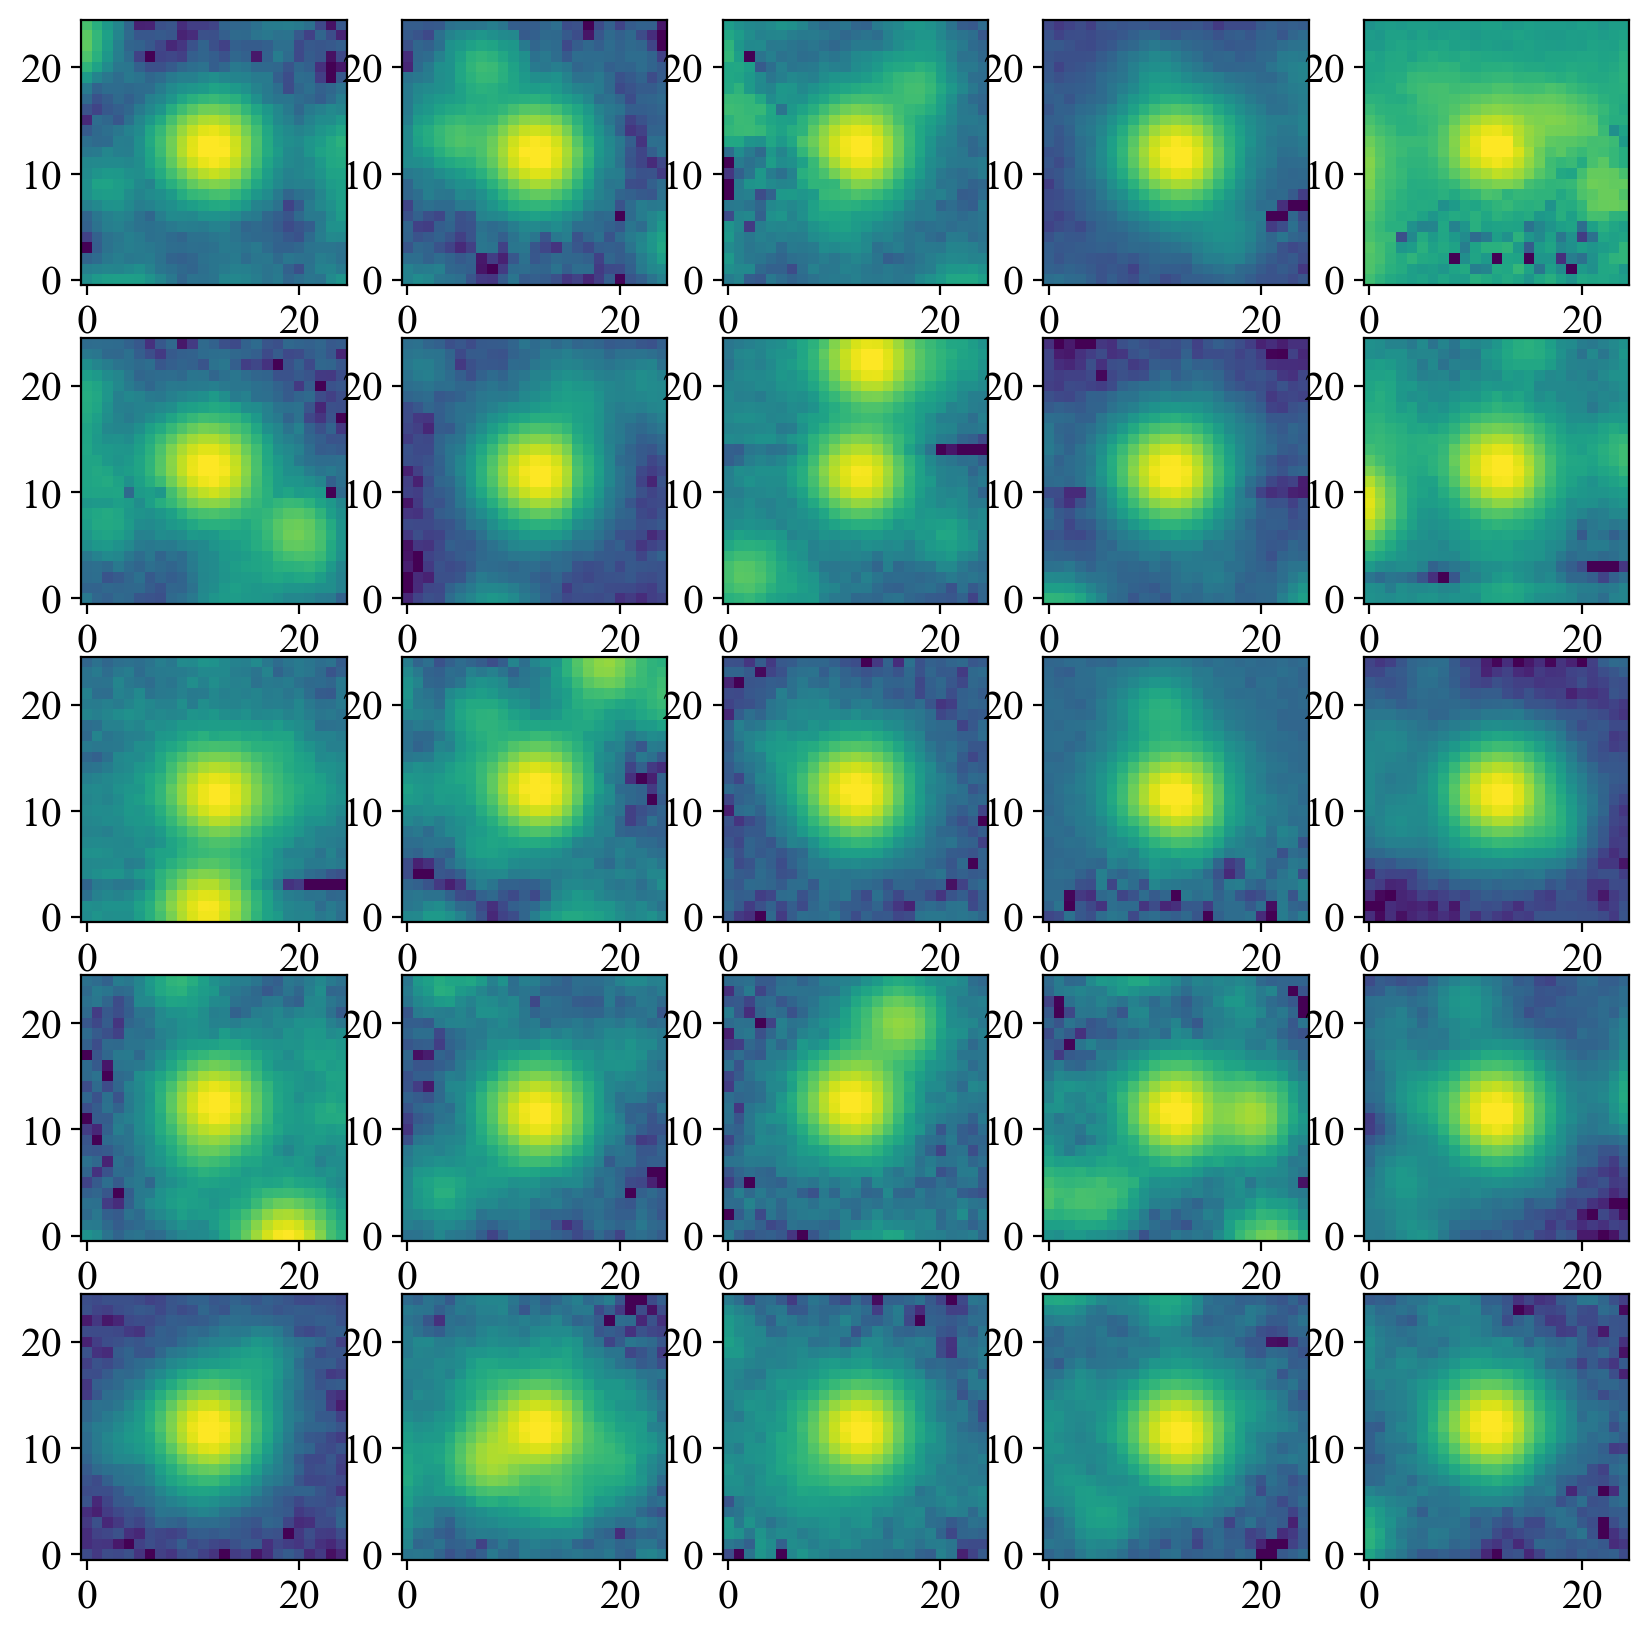

In [6]:
# extract cutouts of our selected stars
stars = extract_stars(nddata, stars_tbl, size=size)

# plot cutouts
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent=99.0)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

# derive fwhm from aperture statistics
cap = CircularAperture(stars.center_flat, size/5.)
apstat = ApertureStats(data, cap)

fwhm_mean, fwhm_med, fwhm_std = sigma_clipped_stats(apstat.fwhm.value,
                                                    sigma=3.0)

In [7]:

def get_epsf(stars, band,
             oversampling=4, maxiters=10, smoothing_kernel='quadratic',
             show=True, ncols=10, figsize=(10, 6)):
    
    if show:
        nrows = int(np.ceil(len(stars)/ncols))
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,
                               squeeze=True)
        axs = axs.ravel()
        for ax in axs:
            ax.axis('off')
        for i in range(len(stars)):
            norm = simple_norm(stars[i], 'log', percent=99.)
            axs[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
        fig.text(0.95,0.05,f'{band}-band',
                  ha='right', va='bottom', fontsize=15)
        # plt.title(f'Picked stars to model PSF ({band})')
        plt.tight_layout()
        
    epsf_builder = EPSFBuilder(oversampling=oversampling, maxiters=maxiters,
                               progress_bar=False,
                               smoothing_kernel=smoothing_kernel)  
    epsf, fitted_stars = epsf_builder(stars)
    
    if show:
        plt.figure()
        norm = simple_norm(epsf.data, 'log', percent=99.)
        plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
        plt.title(f'Effective PSF ({band})')
        plt.colorbar()
        
    return epsf


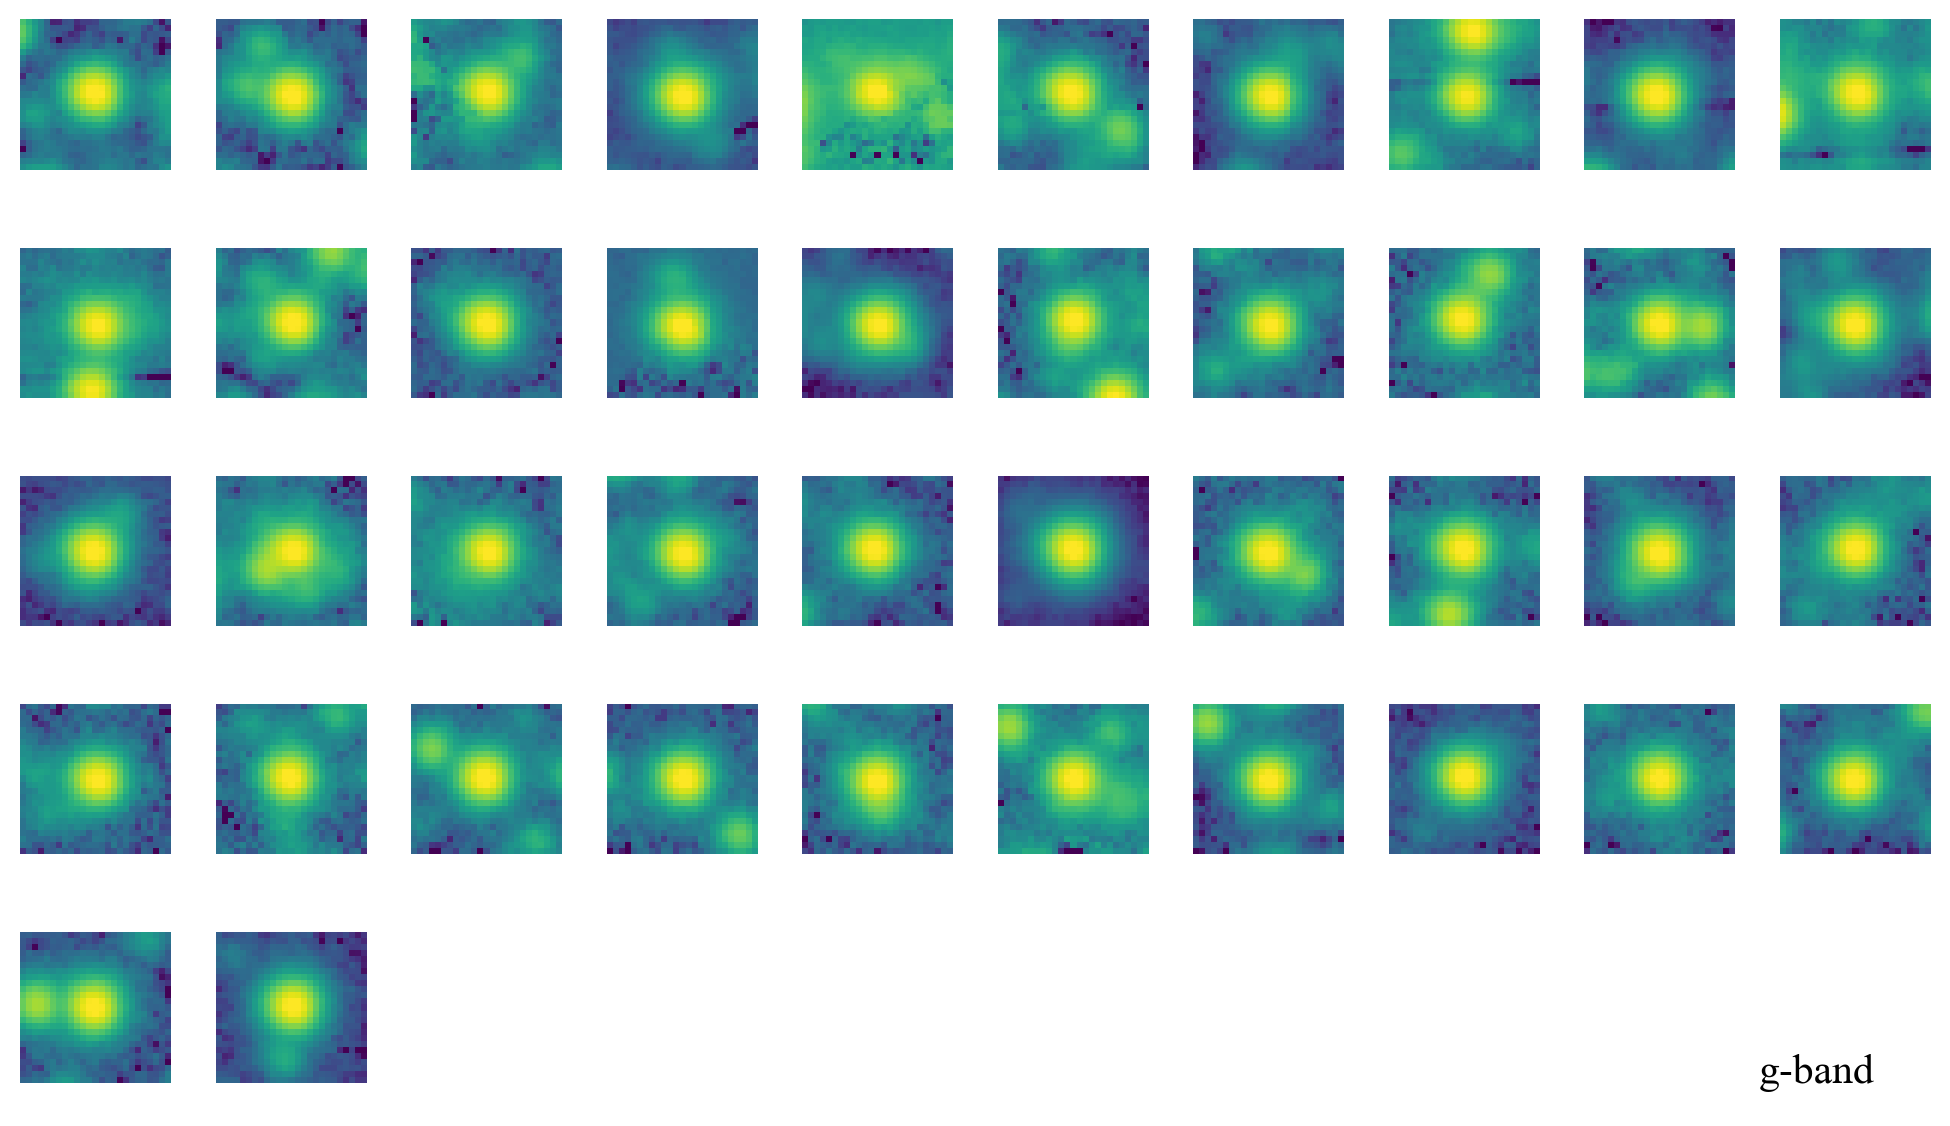

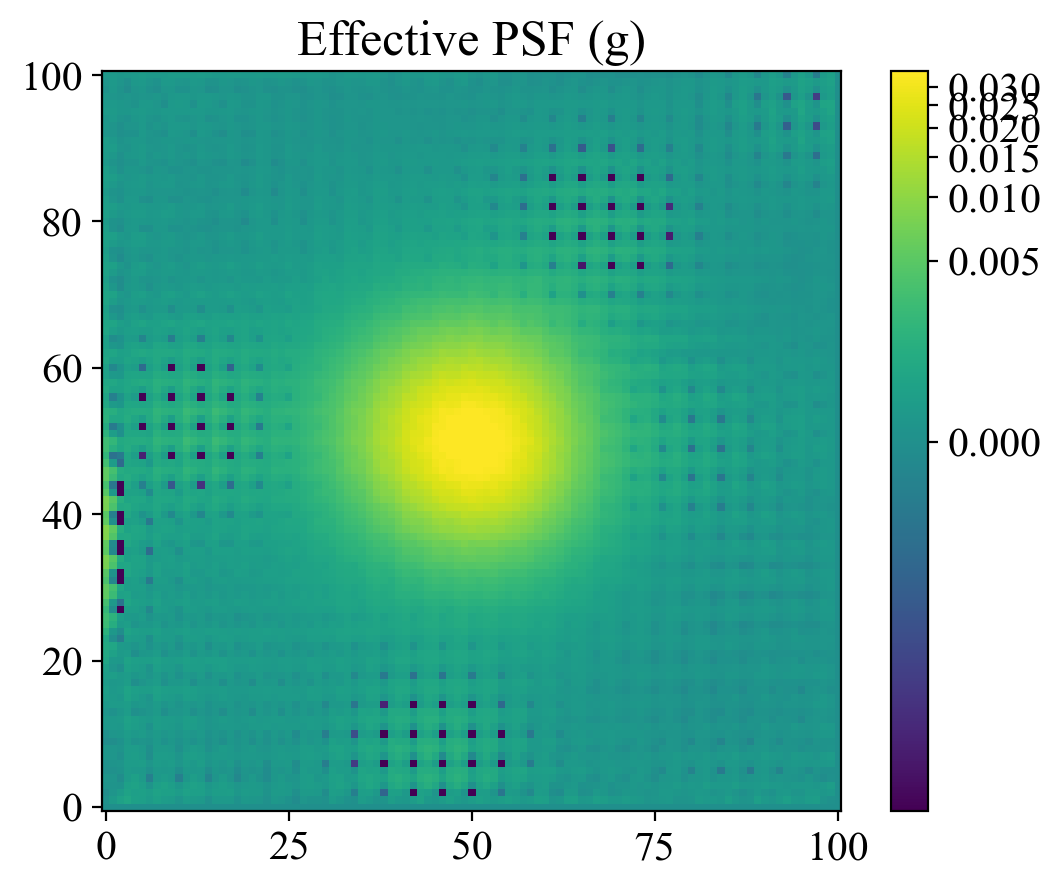

In [9]:
# substar procedure
# subtract adjacent star profiles using the epsf model we obtained.

def substar(stars, psf_model, threshold, fwhm, band, peakmax=None, show=True, ncols=10, figsize=(10, 6)):
    for star in stars:
        finder = DAOStarFinder(threshold=threshold, fwhm=fwhm,
                               minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                               sharplo=0.0, sharphi=2.0, peakmax=peakmax))
        found = finder(star)
        